In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

from sklearn.inspection import permutation_importance
import lightgbm as lgb

### Creation of more features

In [203]:
df_final = pd.read_feather("./data/final_data.feather")

In [204]:
df_final['1year_price_variation'] = (df_final['1year_price'] - df_final['prices_avg']) / df_final['prices_avg']
df_final['Baseline'] = df_final.groupby('asset_num')['1year_price_variation'].shift(4)
#df_final['1quarter_price_variation'] = df_final.groupby('asset_num')['prices_avg'].pct_change(1)

In [205]:
def calculate_sp500_return() -> float:
    sp500 = pd.read_csv("./data/SP500_TR.csv")
    sp500['date'] = pd.to_datetime(sp500['date']).dt.to_period('Q')
    sp500 = sp500.groupby('date').apply(lambda group: group.loc[group['date'].idxmax()]).reset_index(drop=True)
    sp500['1year_sp500_return'] = (sp500['SP500'].shift(-4) - sp500['SP500']) / sp500['SP500']
    sp500 = sp500[sp500['date'] < '2023Q4']
    return sp500[['date', '1year_sp500_return']]

sp500 = calculate_sp500_return()
sp500.head()

C:\Users\ALEX\AppData\Local\Temp\ipykernel_20324\3137064614.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sp500 = sp500.groupby('date').apply(lambda group: group.loc[group['date'].idxmax()]).reset_index(drop=True)


,date,1year_sp500_return
0,2005Q1,0.057696
1,2005Q2,0.127167
2,2005Q3,0.091986
3,2005Q4,0.106072
4,2006Q1,0.157942


In [206]:
df_final = df_final.merge(sp500, left_on='quarter', right_on='date', how='left').drop(columns='date')
df_final['asset_return_diff_sp500'] = df_final['1year_price_variation'] - df_final['1year_sp500_return']
df_final['asset_return_gt_sp500'] = df_final['asset_return_diff_sp500'] > 0

Creating new features related to the EV or oter features features and deleting original ones, p.e.: ebit, ebitda, net income, revenue.

In [207]:
df_final['EV_EBITDA'] = df_final['ev'] / df_final['ebitda']
df_final['EV_EBIT'] = df_final['ev'] / df_final['ebit']
df_final['P_B_ratio'] = df_final['prices_avg'] / (df_final['T_assets'] - df_final['T_debt'])

df_final['Debt_to_Equity'] = df_final['T_debt'] / (df_final['T_assets'] - df_final['T_debt'])
df_final['Net_Debt_to_EBITDA'] = df_final['net_debt'] / df_final['ebitda']

df_final['Asset_Turnover'] = df_final['T_rev'] / df_final['T_assets']
df_final['Cash_Conversion_Ratio'] = df_final['cash'] / df_final['T_rev']

In [208]:
irrelevant_features = ['cap_ex', 'cash', 'ebit', 'ebitda', 'net_inc', 'T_assets', 'T_debt', 'T_rev']
df_final = df_final.drop(columns=irrelevant_features, errors='ignore')

# Handle missing or infinite values
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)

In [210]:
info_cols = ['asset_num','quarter','sector','survivor','prices_avg','1year_price','prices_std','1year_price_variation','1year_sp500_return','asset_return_diff_sp500']
target_col = 'asset_return_gt_sp500'
df_final['new_sector'] = df_final['new_sector'].astype('category')

feature_cols = [col for col in df_final.columns if col not in info_cols + [target_col]]
print(df_final[feature_cols].isna().sum())

dil_shares                284
new_sector                  0
ebit_marg                2741
ebitda_marg              2796
net_marg                  387
ROA                       405
ROE                       405
debts_assets              396
net_debt                  431
cash_ratio               1673
net_income_per_share      564
price_earning_ratio       565
ev                        611
Baseline                 3455
EV_EBITDA                3007
EV_EBIT                  2954
P_B_ratio                 396
Debt_to_Equity            396
Net_Debt_to_EBITDA       2846
Asset_Turnover            405
Cash_Conversion_Ratio     440
dtype: int64


### Creation of the dataset partitions to train the model

In [211]:
df_final['quarter'] = df_final['quarter'].astype('str')
df_final = df_final[~df_final['quarter'].isin(['2005Q1','2005Q2','2005Q3','2005Q4'])]

In [212]:
unique_quarters = df_final['quarter'].astype('str').unique()
unique_quarters

array(['2006Q1', '2006Q2', '2006Q3', '2006Q4', '2007Q1', '2007Q2',
       '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3', '2008Q4',
       '2009Q1', '2009Q2', '2009Q3', '2009Q4', '2010Q1', '2010Q2',
       '2010Q3', '2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4',
       '2012Q1', '2012Q2', '2012Q3', '2012Q4', '2013Q1', '2013Q2',
       '2013Q3', '2013Q4', '2014Q1', '2014Q2', '2014Q3', '2014Q4',
       '2015Q1', '2015Q2', '2015Q3', '2015Q4', '2016Q1', '2016Q2',
       '2016Q3', '2016Q4', '2017Q1', '2017Q2', '2017Q3', '2017Q4',
       '2018Q1', '2018Q2', '2018Q3', '2018Q4', '2019Q1', '2019Q2',
       '2019Q3', '2019Q4', '2020Q1', '2020Q2', '2020Q3', '2020Q4',
       '2021Q1', '2021Q2', '2021Q3', '2021Q4', '2022Q1', '2022Q2',
       '2022Q3', '2022Q4', '2023Q1', '2023Q2', '2023Q3'], dtype=object)

In [213]:
def prepare_train_test_data(dataset: pd.DataFrame, quarters_col: str, features: list[str], target: str, window_size:int=10) -> list[Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]]:
    
    data = dataset.sort_values(by=quarters_col)
    unique_quarters = data[quarters_col].unique()
    datasets = {}

    
    for i in range(len(unique_quarters) - window_size):
        train_quarters = unique_quarters[i:i + window_size]
        test_quarter = unique_quarters[i + window_size]
        
        train_data = data[data[quarters_col].isin(train_quarters)]
        test_data = data[data[quarters_col] == test_quarter]
        

        X_train = train_data[features]
        y_train = train_data[target]
        X_test = test_data[features]
        y_test = test_data[target]
        
        datasets[str(test_quarter)] = (X_train, y_train, X_test, y_test)
        
    return datasets

In [214]:
window_size = 20
datasets = prepare_train_test_data(df_final, 'quarter', feature_cols, target_col, window_size=window_size)

In [215]:
def return_learning_curve(results:dict, set_:str) -> pd.DataFrame:
    learning_curves = pd.DataFrame()
    for quarter in results:
        learning_curve = pd.DataFrame(results[(quarter)][set_])
        learning_curve["n_trees"] = list(range(len(learning_curve)))
        learning_curve["quarter"] = quarter
        learning_curves= pd.concat([learning_curves,learning_curve])
        
    for column in learning_curves.columns:
        if column not in ["n_trees","quarter"]:        
            first_metric = learning_curves[[column,"quarter"]].drop_duplicates(["quarter"])
            first_metric = first_metric.rename(columns = {column:"first_"+column})
            learning_curves = pd.merge(learning_curves,first_metric,on = ["quarter"])
            learning_curves["norm_"+column] = (learning_curves[column] - learning_curves["first_"+column] )/learning_curves["first_"+column]
            learning_curves = learning_curves.drop(columns = "first_"+column)
    learning_curves["quarter"] = learning_curves["quarter"].astype(str)
    
    return learning_curves

### Searching for the best hyperparameters

C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


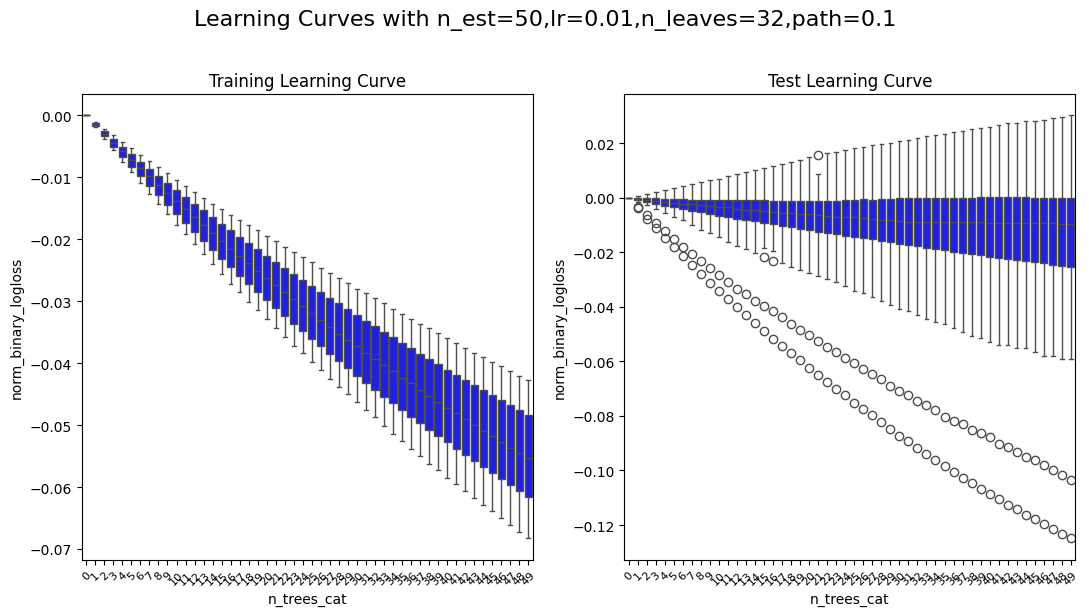

C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


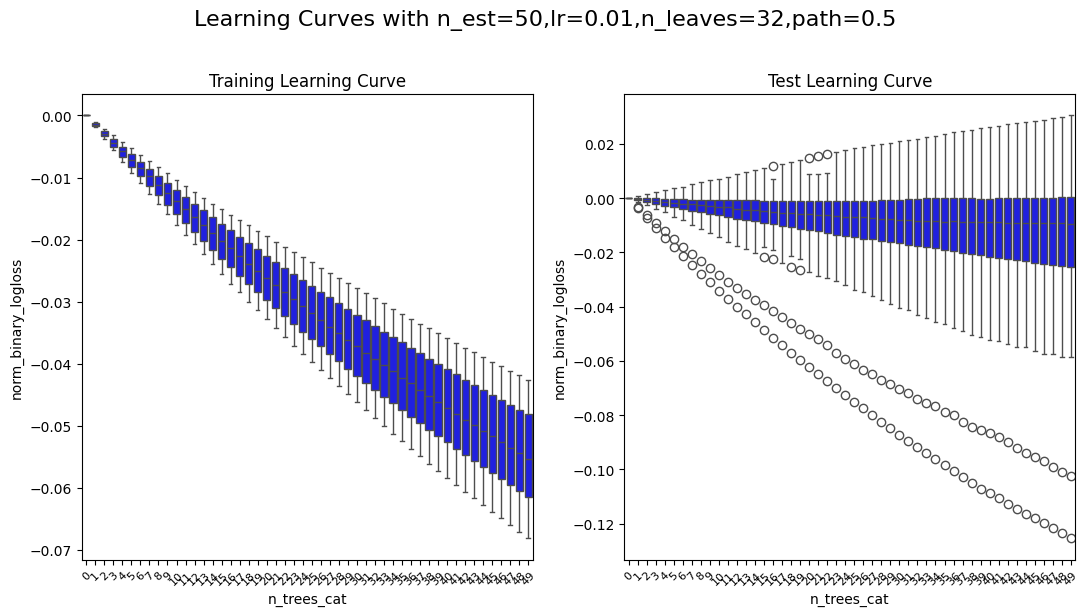

C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


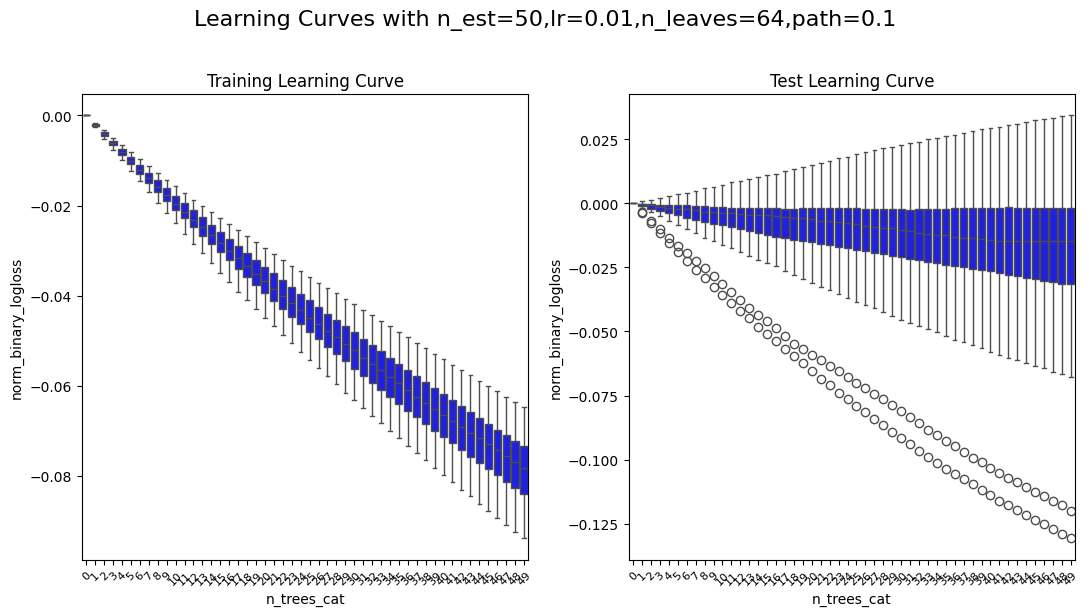

C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


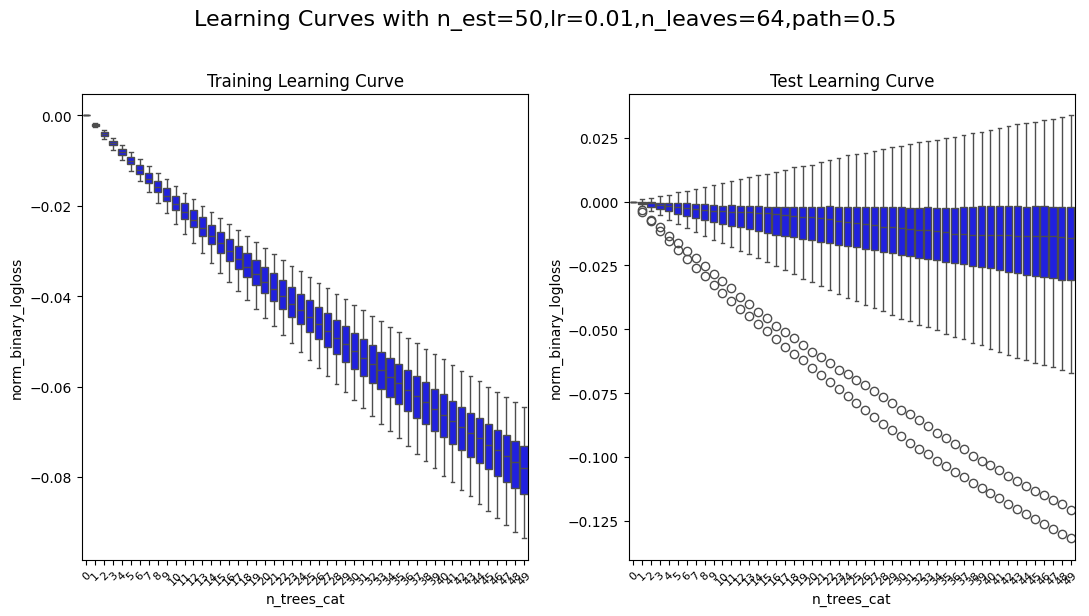

C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


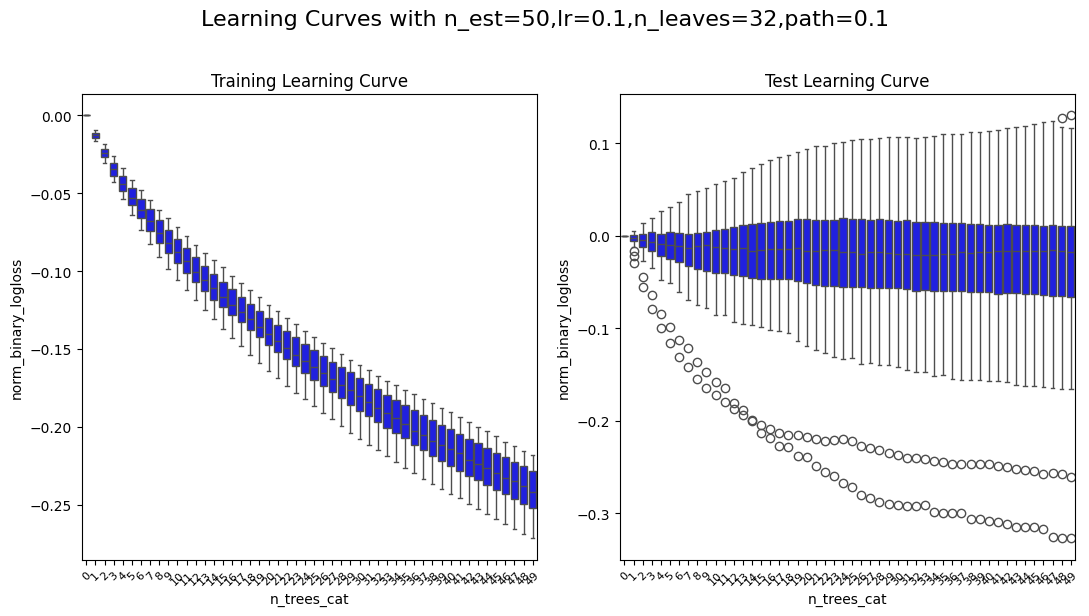

C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


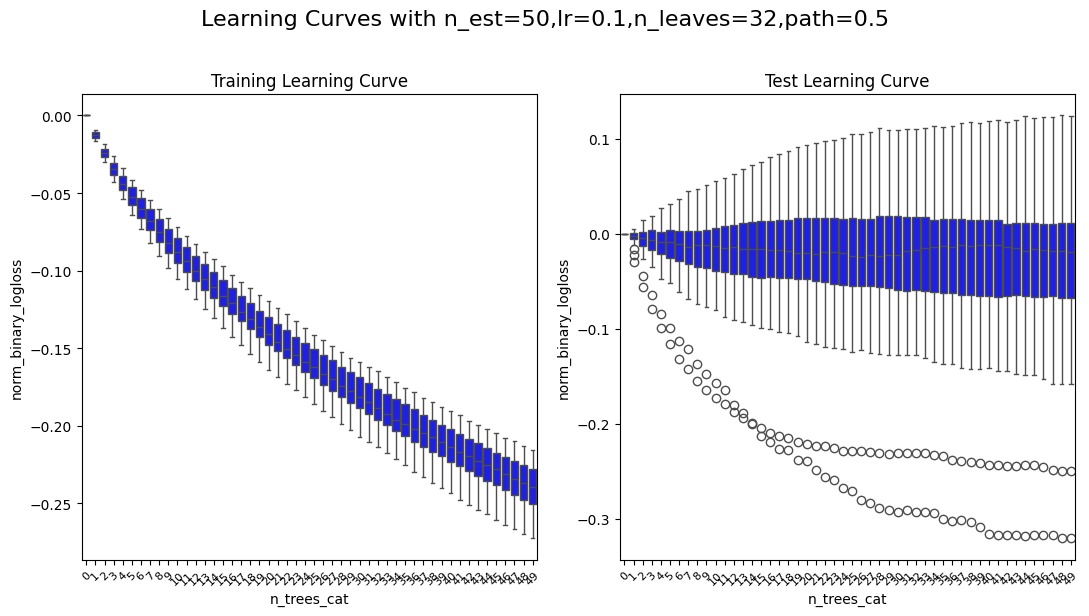

C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


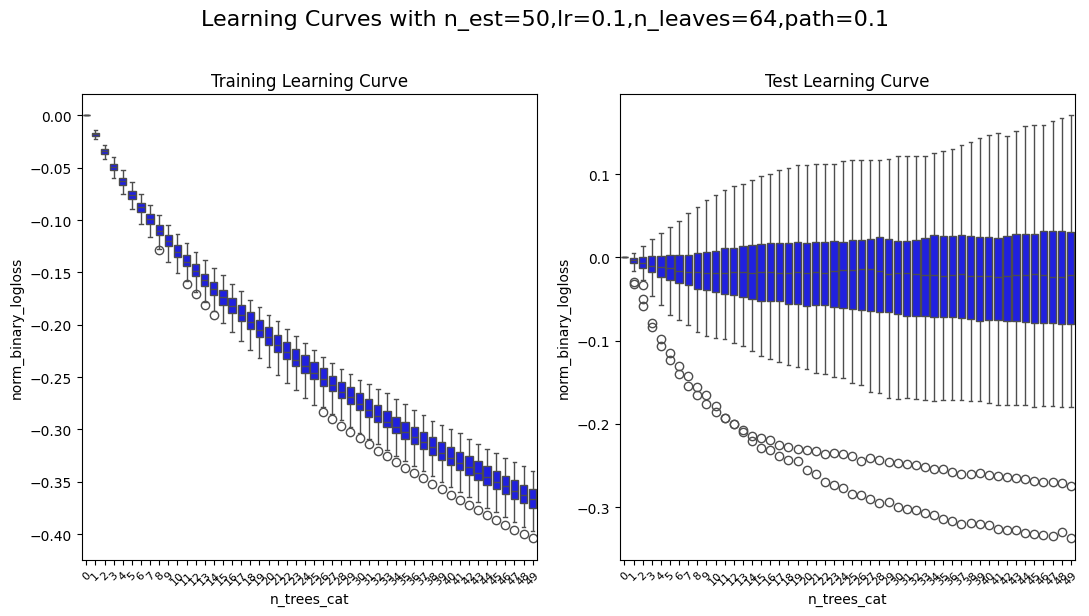

C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


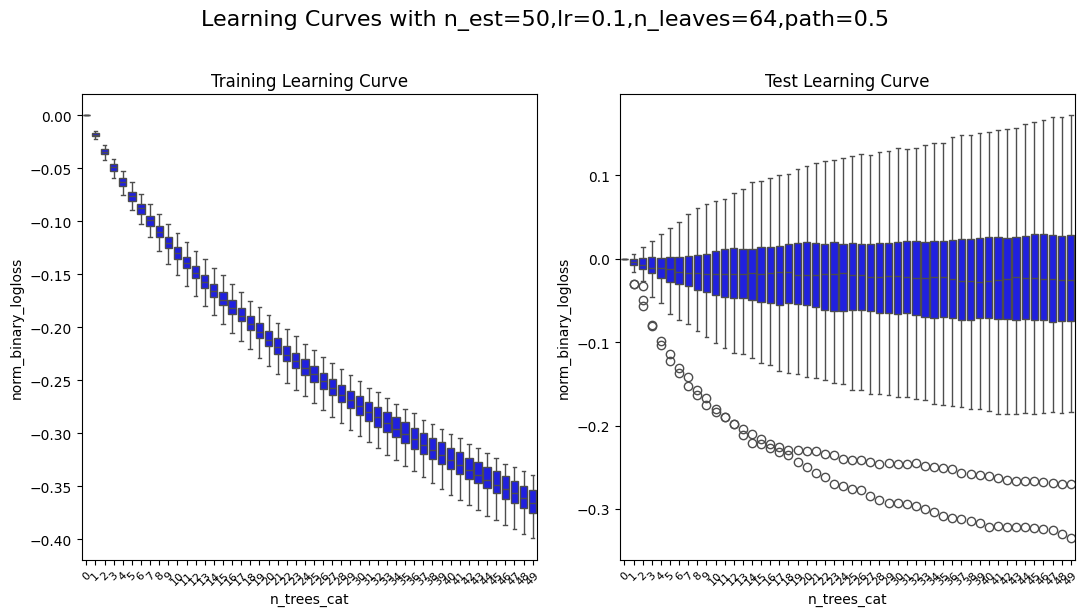

C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


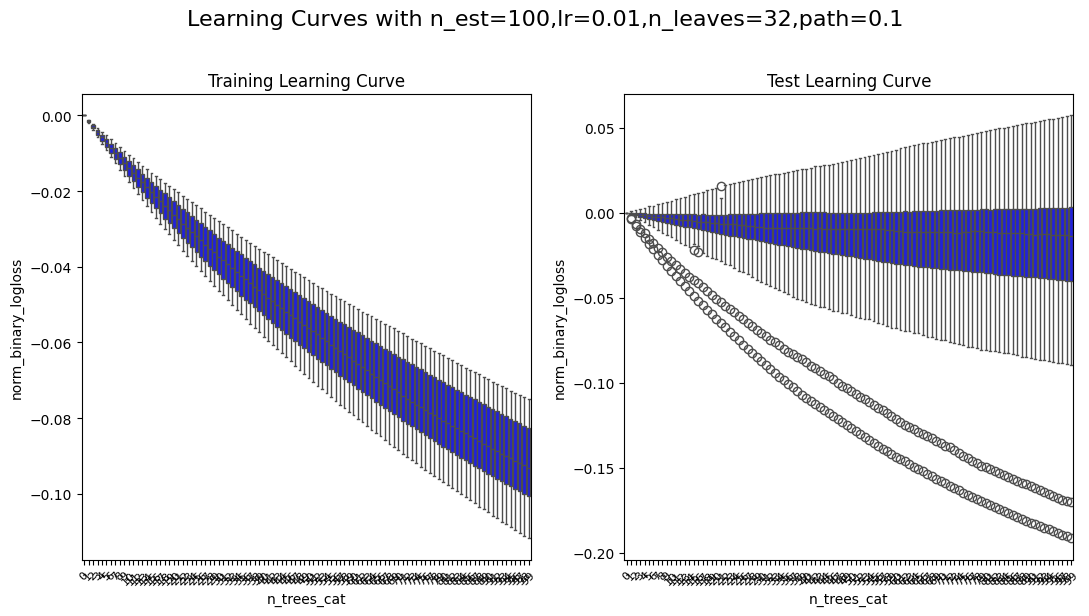

C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


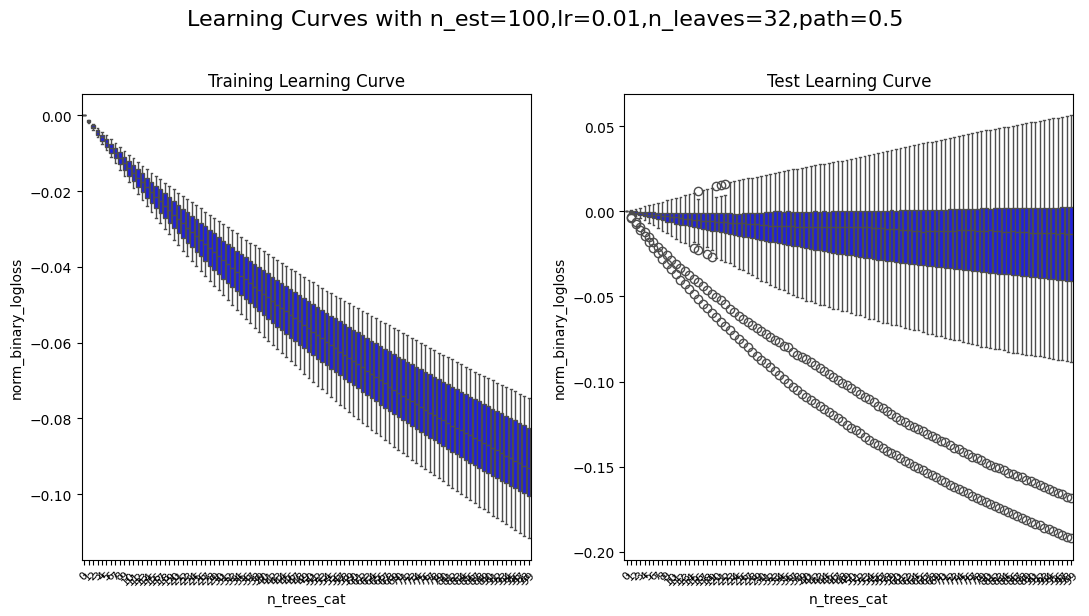

C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


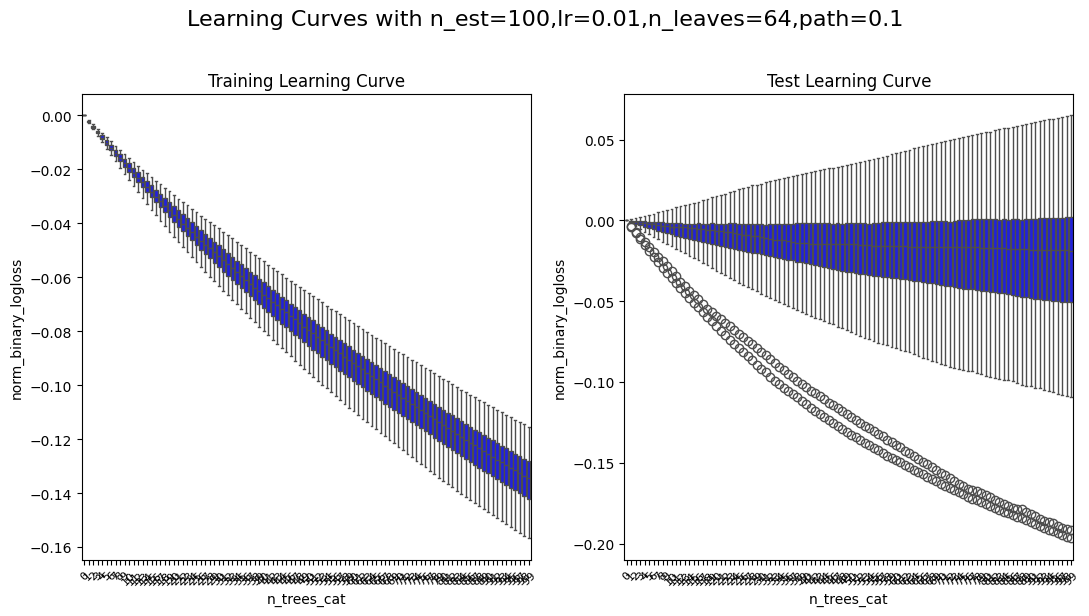

C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


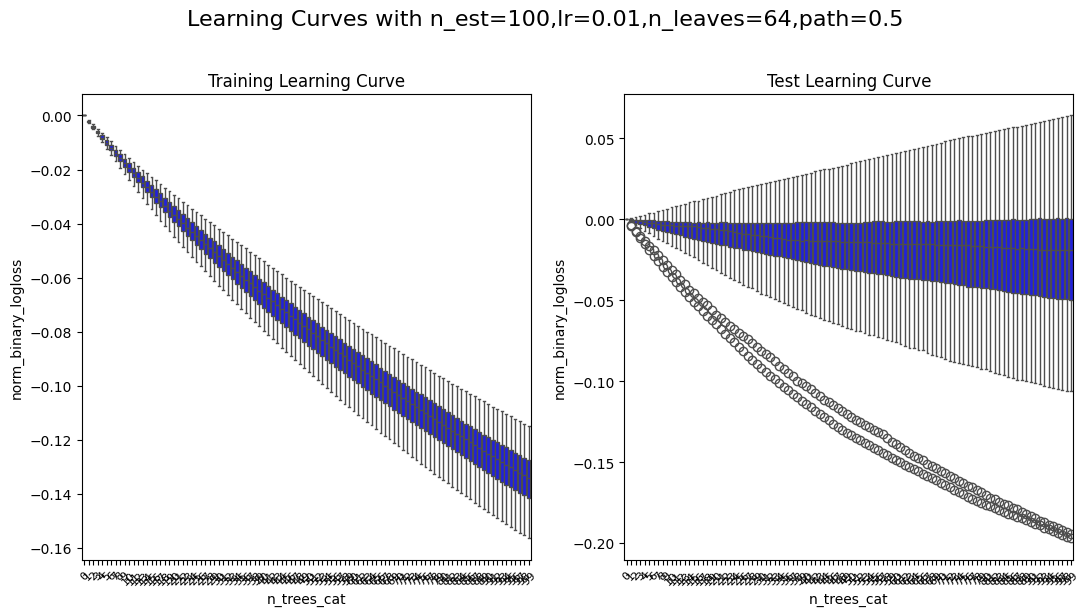

C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


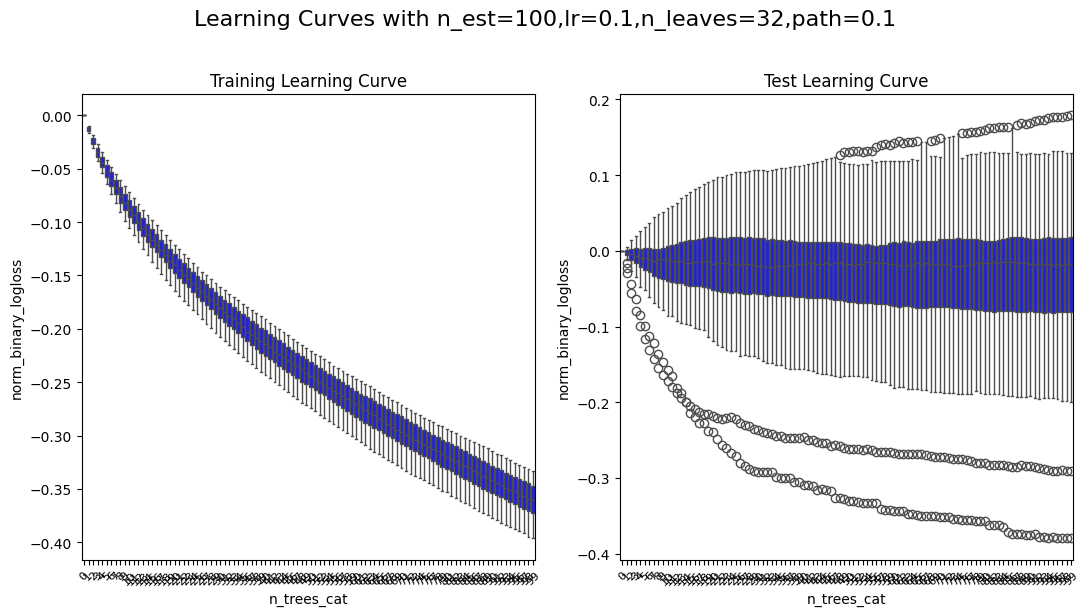

C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


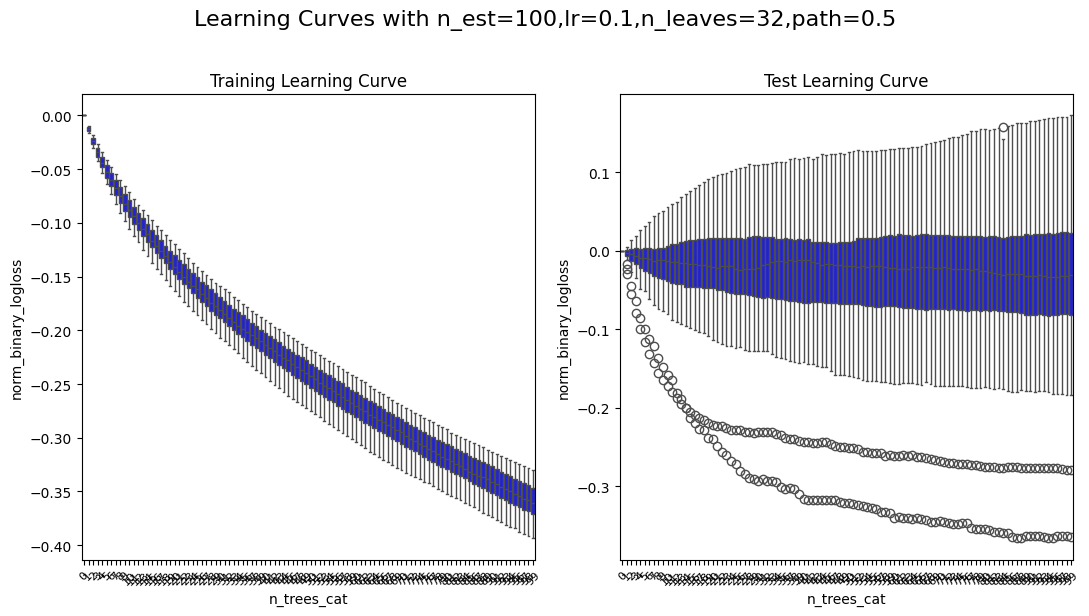

C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


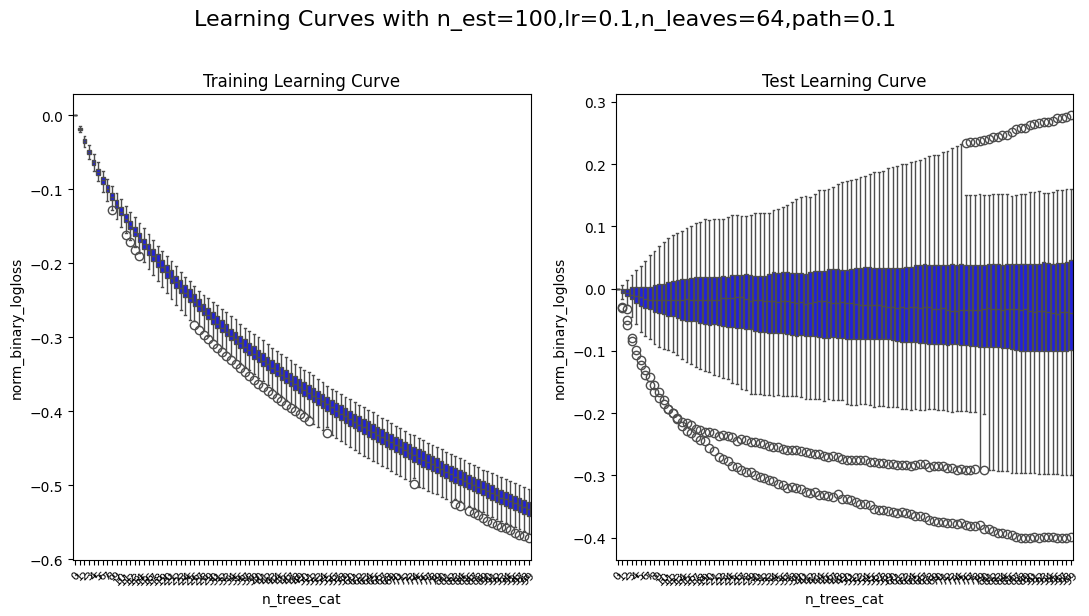

C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
C:\Users\ALEX\AppData\Local\Temp\ipykernel_25956\1252130185.py:69: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)


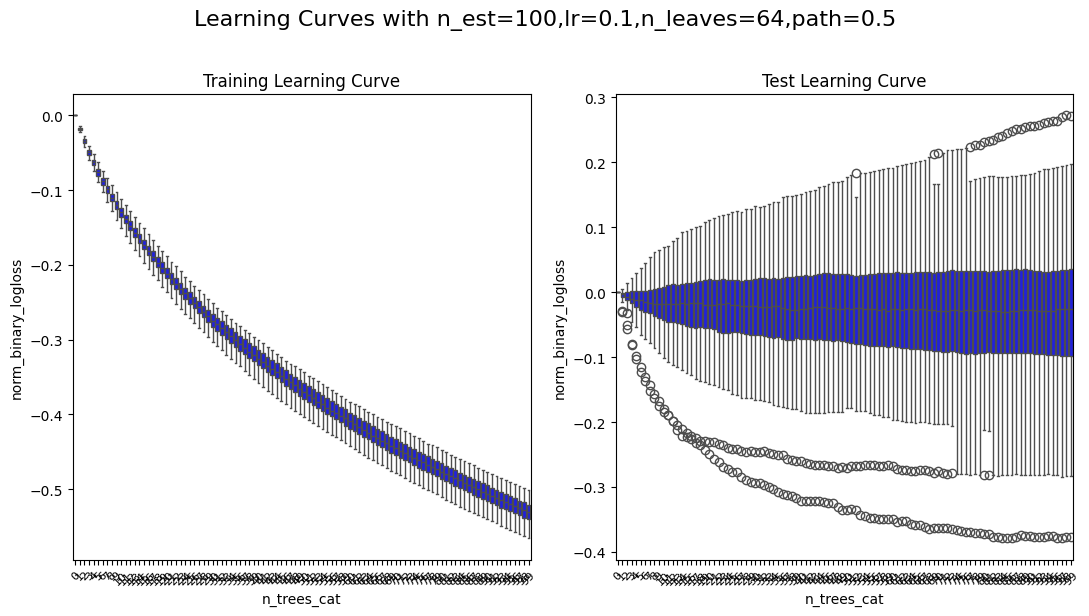

In [19]:
# This code is commented to avoid running it by mistake but it is left here to show the results
# params_lgb = {
#     'metric': 'logloss',
#     'random_state': 1,
#     'verbose': 0,
#     'n_estimators': 50,
#     'learning_rate': 0.01,
#     'num_leaves': 32,
#     'path_smooth': 0.1
# }


# for n_estimators in [50, 100]:
#     for learning_rate in [0.01, 0.1]:
#         for num_leaves in [32, 64]:
#             for path_smooth in [0.1, 0.5]:
#                 params_lgb = {
#                     'metric': 'logloss',
#                     'random_state': 1,
#                     'verbose': 0,
#                     'n_estimators': n_estimators,
#                     'learning_rate': learning_rate,
#                     'num_leaves': num_leaves,
#                     'path_smooth': path_smooth
#                 }
                
#                 models_list = {}
#                 results_list = {}
#                 predictions_list = {}
#                 compute_importance = True
#                 permut_importances_list = {}
#                 categorical_features = ['new_sector']

#                 for i in range(len(datasets)):
#                     test_quarter = unique_quarters[i + window_size]
#                     #print(f"Training model to test quarter: {test_quarter}")

#                     X_train, y_train, X_test, y_test = datasets[unique_quarters[i+window_size]]

#                     eval_result = {}

#                     model = lgb.LGBMClassifier(**params_lgb)

#                     model.fit(
#                         X_train, y_train,
#                         categorical_feature=categorical_features,
#                         eval_set=[(X_test, y_test), (X_train, y_train)],
#                         eval_metric='logloss',
#                         callbacks=[lgb.record_evaluation(eval_result=eval_result)]
#                     )
                    
#                     results_list[(test_quarter)] = eval_result


#                 test_lc = return_learning_curve(results_list,"valid_0")
#                 train_lc = return_learning_curve(results_list,"training")

#                 train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(train_lc['n_trees'].unique()))
#                 test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))



#                 fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6))

#                 sns.boxplot(data=train_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue', ax=ax1)
#                 ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, fontsize=8)
#                 ax1.set_title('Training Learning Curve')

#                 sns.boxplot(data=test_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue', ax=ax2)
#                 ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, fontsize=8)
#                 ax2.set_title('Test Learning Curve')

#                 plt.suptitle(f'Learning Curves with n_est={n_estimators},lr={learning_rate},n_leaves={num_leaves},path={path_smooth}', fontsize=16, y=1.02)

#                 plt.tight_layout()  
#                 plt.savefig(f'./data/learning_curves/lc_{n_estimators}_{learning_rate}_{num_leaves}_{path_smooth}.png',dpi=300, bbox_inches='tight')
#                 plt.show()

After comparing the learning curves, we choose the model with Lr = 0.01, n_leaves = 64, path_smooth = 0.1, and n_estimators = 100.

In [281]:
params_lgb = {
    'objective': 'binary',
    'metric': 'logloss',
    'random_state': 1,
    'verbose': 0,
    'n_estimators': 100,
    'learning_rate': 0.01,
    'num_leaves': 64,
    'path_smooth': 0.1
}



models_list = {}
results_list = {}
predictions_list = {}
compute_importance = True
permut_importances_list = {}
categorical_features = ['new_sector']

for i in range(len(datasets)):
    test_quarter = unique_quarters[i + window_size]
    print(f"Training model to test quarter: {test_quarter}")
    
    X_train, y_train, X_test, y_test = datasets[unique_quarters[i+window_size]]
    
    eval_result = {}
    
    model = lgb.LGBMClassifier(**params_lgb)
    
    model.fit(
        X_train, y_train,
        categorical_feature=categorical_features,
        eval_set=[(X_test, y_test), (X_train, y_train)],
        eval_metric='logloss',
        callbacks=[lgb.record_evaluation(eval_result=eval_result)]
    )
    
    if compute_importance:
        r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)
        feature_names = X_test.columns
        df_permutation_importance = pd.DataFrame({'importance': r.importances_mean, 'feature': feature_names})
    else:
        df_permutation_importance = pd.DataFrame()
    
    
    models_list[(test_quarter)] = model
    results_list[(test_quarter)] = eval_result
    predictions_list[(test_quarter)] = model.predict_proba(X_test)[:,1]
    permut_importances_list[(test_quarter)] = df_permutation_importance

Training model to test quarter: 2011Q1
Training model to test quarter: 2011Q2
Training model to test quarter: 2011Q3
Training model to test quarter: 2011Q4
Training model to test quarter: 2012Q1
Training model to test quarter: 2012Q2
Training model to test quarter: 2012Q3
Training model to test quarter: 2012Q4
Training model to test quarter: 2013Q1
Training model to test quarter: 2013Q2
Training model to test quarter: 2013Q3
Training model to test quarter: 2013Q4
Training model to test quarter: 2014Q1
Training model to test quarter: 2014Q2
Training model to test quarter: 2014Q3
Training model to test quarter: 2014Q4
Training model to test quarter: 2015Q1
Training model to test quarter: 2015Q2
Training model to test quarter: 2015Q3
Training model to test quarter: 2015Q4
Training model to test quarter: 2016Q1
Training model to test quarter: 2016Q2
Training model to test quarter: 2016Q3
Training model to test quarter: 2016Q4
Training model to test quarter: 2017Q1
Training model to test qu

In [282]:
test_lc = return_learning_curve(results_list,"valid_0")
train_lc = return_learning_curve(results_list,"training")

train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(train_lc['n_trees'].unique()))
test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))

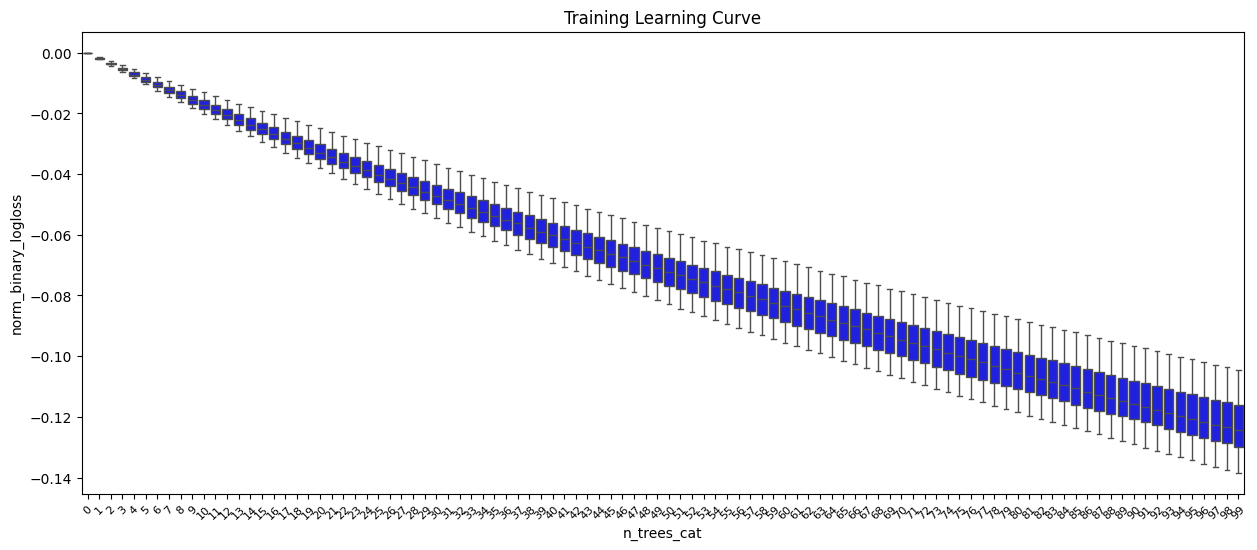

In [283]:
plt.subplots(figsize=(15, 6))
sns.boxplot(data=train_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue')
plt.xticks(rotation=45, fontsize=8)
plt.title('Training Learning Curve')
plt.show()

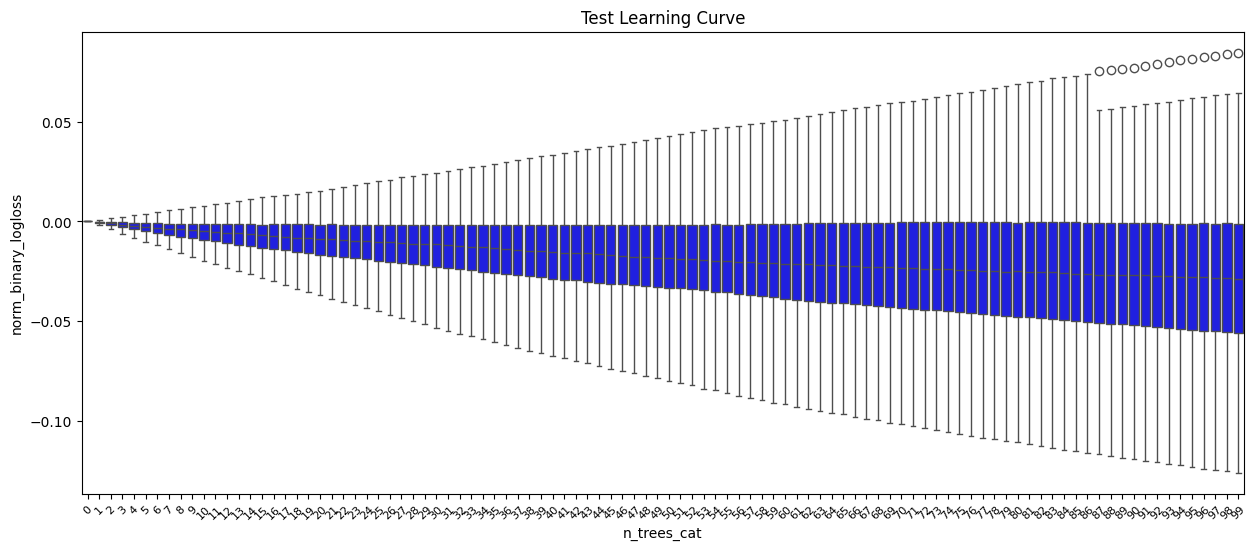

In [284]:
plt.subplots(figsize=(15, 6))
sns.boxplot(data=test_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue')
plt.xticks(rotation=45, fontsize=8)
plt.title('Test Learning Curve')
plt.show()

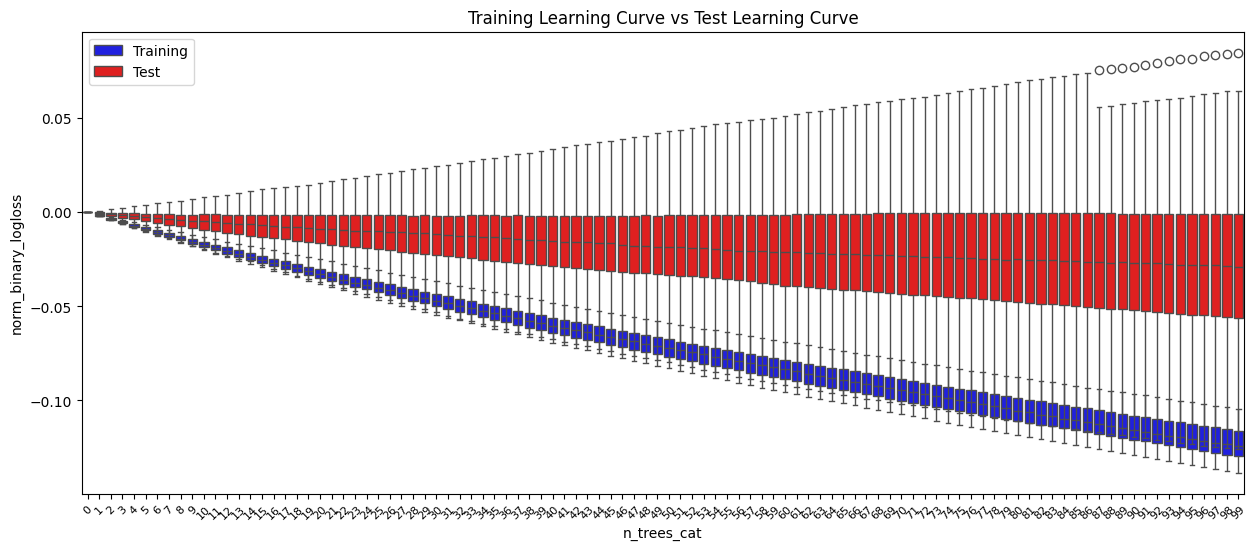

In [285]:
plt.subplots(figsize=(15, 6))
sns.boxplot(data=train_lc, x='n_trees_cat', y='norm_binary_logloss', color='blue', label='Training')
sns.boxplot(data=test_lc, x='n_trees_cat', y='norm_binary_logloss', color='red', label='Test')
plt.xticks(rotation=45, fontsize=8)
plt.title('Training Learning Curve vs Test Learning Curve')
plt.legend()
plt.show()

In [286]:
importance_dfs = []

# Generate a DataFrame for each quarter with the permutation importances
for quarter, df_imp in permut_importances_list.items():
    df_imp['quarter'] = quarter
    df_imp['importance'] = df_imp['importance']
    importance_dfs.append(df_imp)

df_importances = pd.concat(importance_dfs, ignore_index=True)

df_importances

,importance,feature,quarter
0,0.021206,dil_shares,2011Q1
1,0.027507,new_sector,2011Q1
2,-0.003184,ebit_marg,2011Q1
3,-0.009350,ebitda_marg,2011Q1
4,0.000136,net_marg,2011Q1
...,...,...,...
1066,0.001815,P_B_ratio,2023Q3
1067,0.004435,Debt_to_Equity,2023Q3
1068,0.005780,Net_Debt_to_EBITDA,2023Q3
1069,0.011089,Asset_Turnover,2023Q3


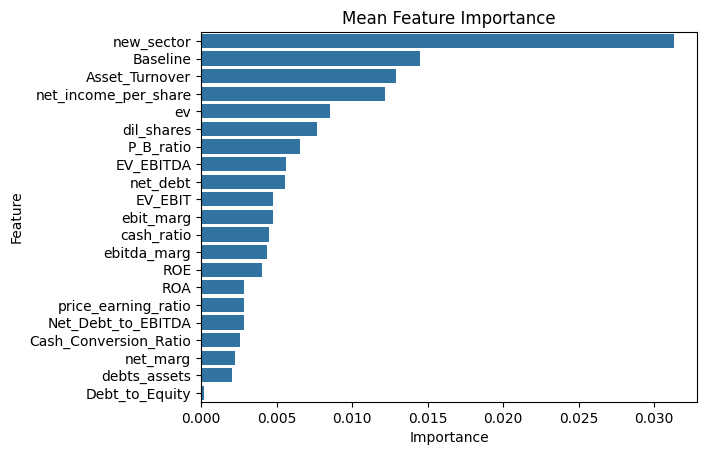

In [287]:
df_importances_mean = df_importances.groupby('feature')['importance'].mean().sort_values(ascending=False)
sns.barplot(x=df_importances_mean, y=df_importances_mean.index)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Mean Feature Importance')
plt.show()

In [292]:
df_importances_sorted = df_importances.sort_values(by=['quarter','importance'], ascending=[True,False]).reset_index(drop=True)
df_importances_sorted["rank"] = df_importances_sorted.groupby(["quarter"]).cumcount()
r_all_permutation_importances = df_importances_sorted[df_importances_sorted["rank"]<3]

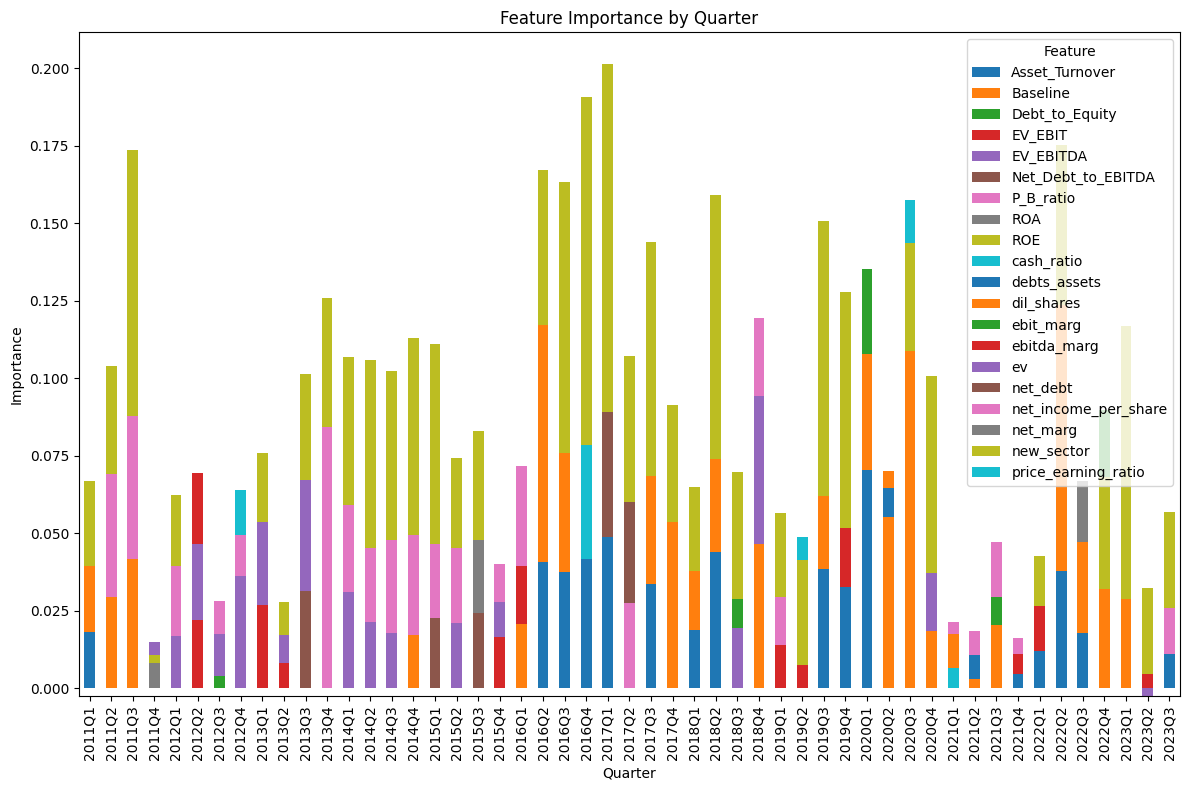

In [293]:
pivot_df = r_all_permutation_importances.pivot(index="quarter", columns="feature", values="importance")

pivot_df.plot(
    kind="bar",
    stacked=True,
    figsize=(12, 8),
)
plt.xlabel("Quarter")
plt.ylabel("Importance")
plt.title("Feature Importance by Quarter")
plt.legend(title="Feature")
plt.tight_layout()

plt.show()